## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, I have been working to understand the results of an A/B test run by an e-commerce website. my goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [1]:
# To get started, let's import our libraries.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#setting the seed to assure we get the same result for every try
random.seed(42)

In [2]:
# Read in the dataset and take a look at the top few rows here:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the numbers of rows and unique users in the dataset.

In [3]:
df.shape[0]

294478

In [4]:
df.user_id.nunique()

290584

In [5]:
# The proportion of users converted
df.converted.mean()

0.11965919355605512

In [6]:
# The number of times the `new_page` and `treatment` don't match
df.query('landing_page == "new_page" and group != "treatment"').count()[0] + df.query('landing_page != "new_page" and group == "treatment"').count()[0]

3893

In [7]:
# Find missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. So we need to delete these rows and store the new dataframe in **df2**.

In [8]:
df_treat = df.query('landing_page == "new_page" and group == "treatment"')

df_control = df.query('landing_page == "old_page" and group == "control"')

df2 = pd.concat([df_treat, df_control])

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
# Check the number of unique user_id in df2
df2.user_id.nunique()

290584

Find repeat **user_id** and remove one of the rows with a duplicate **user_id**

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
# The row information for the repeat **user_id**
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df2.drop_duplicates('user_id', keep='first', inplace=True)

Find the probability of an individual converting 

In [14]:
# regardless of the page they receive
convert_prop = df2.converted.mean()
convert_prop

0.11959708724499628

In [15]:
# Given that an individual was in the `control` group
control_convert = df2[df2.group == 'control'].converted.mean()
control_convert

0.1203863045004612

In [16]:
# Given that an individual was in the `treatment` group
treat_convert = df2[df2.group == 'treatment'].converted.mean()
treat_convert

0.11880806551510564

In [17]:
# Rate difference between two groups
obs_diff = treat_convert - control_convert
obs_diff

-0.0015782389853555567

In [18]:
# The probability that an individual received the new page
(df2.group == "treatment").mean()

0.50006194422266881

Firstly, we can see that out dataset is balanced, since control group and treatment group have same size. Then, from the result we got from comparing the conversion rate between these two groups, we find out that treatment group has lower conversion rate than control group. So there is no sufficient evidence shows that new page leads to more conversions. However, we just used one sample. To get more reliable conclusions, we're going to do hypothesis test and get more samples with random sampling technique as shown below.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, we only consider making the decision just based on all the data provided. We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. Our null and alternative hypothese can be expressed by the relationship of **p_new** and **p_old**, which are the converted rates for the new and old pages.

$$ H_0 : p_{new} - p_{old} \leq 0 $$
$$ H_1 : p_{new} - p_{old}  > 0 $$

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [19]:
# The conversion rate for treatment group under the null
p_new = df2.converted.mean()
p_new

0.11959708724499628

In [20]:
# The conversion rate for control group under the null
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [21]:
# The number of individuals in the treatment group
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

In [22]:
# The number of individuals in the control group
n_old = df2.query('group == "control"').count()[0]
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])

Find $p_{new}$ - $p_{old}$ for the simulated values

In [25]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.001330511546662444

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in former steps. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []

for _ in range(10000):
    old_page = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
    new_page = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
    p_diffs.append(new_page.mean() - old_page.mean())

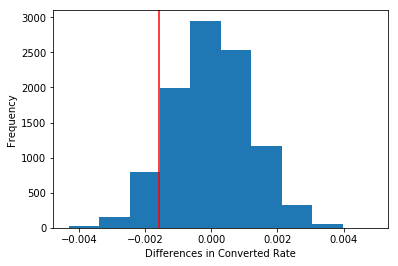

In [27]:
plt.hist(p_diffs)
plt.xlabel('Differences in Converted Rate')
plt.ylabel('Frequency')
plt.axvline(obs_diff, color='r')

Calculate the proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [28]:
prop = (p_diffs > obs_diff).mean()
prop

0.90549999999999997

The p_value is 0.905, which is the probability of obtaining the conversion rate difference in observed data or more extreme values in favor of alternative hypothesis under the assumption that the null hypothesis is true. Since P_value is larger than the significance level we defined before(0.05), we fail to reject the null hypothesis, and the conclusion is that new page doesn't perform better than old page in conversion rate.

We could also use a built-in to achieve similar results.   

Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').count()[0]
convert_new = df2.query('group == "treatment" and converted == 1').count()[0]
n_old = df2.query('group == "control"').count()[0]
n_new = df2.query('group == "treatment"').count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now use `stats.proportions_ztest` to compute the test statistic and p-value.

In [30]:
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

In [31]:
print("z_score is", stat)
print("p_value is", pval)

z_score is -1.31092419842
p_value is 0.905058312759


The calculated values align with the results we obtained before.

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result achieved in the A/B test in Part II above can also be achieved by performing **Logistic Regression**.<br><br> 

The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


Instantiate the regression model, then fit the model using the two columns created above to predict whether or not an individual converts. 

In [33]:
lr = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lr.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 04 Feb 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:24:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p_value(0.190) here is still larger than significance level(0.05). However, it's different from the p_value we calculated before. That's because for coefficients in the regression model, we're using two tailed hypothesis, which means the null hypothesis is $b = 0$ and alternative hypothesis is $b \neq 0$.

There may be other factors we didn't take into consideration. But before adding them into our regression model, we need to make sure that the new variables will not lead to multicollinearity in our data.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We need to read in the **countries.csv** dataset and merge together datasets on the appropriate rows. 

In [34]:
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [35]:
new_df = df2.set_index('user_id').join(country.set_index('user_id'), how='inner')
new_df.head()

,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country
user_id,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA


In [36]:
# Get the number of different values in country
new_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [37]:
# Create dummy variables for countries
new_df[['CA', 'CK', 'US']] = pd.get_dummies(new_df['country'])
new_df.head()

,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country,CA,CK,US
user_id,,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0


In [38]:
# Instantiate and fit the model
lr2 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'CA', 'CK']])
result2 = lr2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 04 Feb 2020   Pseudo R-squ.:               2.323e-05
Time:                        23:24:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
CK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Same as before, the p_value for the coefficients of two new varibles are larger than significance level, we fail to reject the null hypothesis

We would now like to look at an interaction between page and country to see if there significant effects on conversion.  

Create the necessary additional columns, and fit the new model.  

In [39]:
new_df['CA_ab_page'] = new_df['CA']*new_df['ab_page']
new_df['CK_ab_page'] = new_df['CK']*new_df['ab_page']
new_df.head()

,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country,CA,CK,US,CA_ab_page,CK_ab_page
user_id,,,,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,0,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0,1,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0,0,1
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0,1,0


In [40]:
lr3 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'CA', 'CK', 'CA_ab_page', 'CK_ab_page']])
result3 = lr3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 04 Feb 2020   Pseudo R-squ.:               3.482e-05
Time:                        23:24:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
CK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
CK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Conclusion**: None of coefficients show statistical significance results, so there is no evidence to conclude that the interaction between country and page has correlated relationship with user converts.
   In total, we fail to reject the null hypothesis, which means we can't say the new page will have more conversions than the old page.

<a id='conclusions'></a>
## Finishing Up

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0